In [427]:
# The battle of neighborhoods: Opening a new Lebanese restaurant in Los Angeles 

Problem description and background:
Fadi, a Lebanese-American, has been living in San Diego for 12 years, where he runs a family owned restaurant. Since he has been very successful, he is looking to expand his business and opening a new Lebanese restaurant in Los Angeles. LA is a very big city which is home to around 4 million inhabitants. It is considered the heart of the state of California and is a hot spot for tourists and visitors. Since LA is a very diverse city, having an authentic Lebanese restaurant offering fine oriental cuisine would be very appealing to the local population, as well as for visitors.
Since the city is big and has many neighborhoods, Fadi doesn’t know which neighborhood he should pick for the location of his restaurant, in order to maximize his success and eventually his potential revenues. So he calls our data consulting firm to help him figure out the best neighborhoods, and avoid the less attractive ones.

In [428]:
# Import required libraries
from bs4 import BeautifulSoup
import folium
from geopy.geocoders import Nominatim 
import io
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler
from statistics import mean
%matplotlib inline

In [429]:
# DATA ACQUISITION

# List of districts and neighborhoods of Los Angeles
# Get data from wikipedia page, process the page with BeautifulSoup to extract the data
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles').text
soup = BeautifulSoup(website_url,'html')
# soup.prettify()
neighbourhoods_list = soup.findAll('ul')  # in this result set, the useful lists are the 3rd and 4th (table in 2 parts)
# Extracting neighborhoods' list
neighborhoods = []
for item in neighbourhoods_list[2].findAll('li'): # 3rd list
    neighborhoods.append(item.a.renderContents().decode("utf-8"))
for item in neighbourhoods_list[3].findAll('li'): # 4th list
    neighborhoods.append(item.a.renderContents().decode("utf-8"))

print('List of Los Angeles neighborhoods:\n' + "\n".join(neighborhoods))

List of Los Angeles neighborhoods:
Angelino Heights
Arleta
Arlington Heights
Arts District
Atwater Village
Baldwin Hills
Baldwin Hills/Crenshaw
Baldwin Village
Baldwin Vista
Beachwood Canyon
Bel Air, Bel-Air or Bel Air Estates
Benedict Canyon
Beverly Crest
Beverly Glen
Beverly Grove
Beverly Hills Post Office
Beverly Park
Beverlywood
Boyle Heights
Brentwood
Brentwood Circle
Brentwood Glen
Broadway-Manchester
Brookside
Bunker Hill
Cahuenga Pass
Canoga Park
Canterbury Knolls
Carthay
Castle Heights
Central-Alameda
Central City
Century City
Chatsworth
Chesterfield Square
Cheviot Hills
Chinatown
Civic Center
Crenshaw
Crestwood Hills
Cypress Park
Del Rey
Downtown
Eagle Rock
East Gate Bel Air
East Hollywood
Echo Park
Edendale
El Sereno
Elysian Heights
Elysian Park
Elysian Valley
Encino
Exposition Park
Faircrest Heights
Fairfax
Fashion District
Filipinotown, Historic
Financial District
Florence
Flower District
Franklin Hills
Gallery Row
Garvanza
Glassell Park
Gramercy Park
Granada Hills
Green M

In [430]:
# Correcting specific neighborhoods names
for n, i in enumerate(neighborhoods):
    if i == '[33]':
        neighborhoods[n] = 'Pico Robertson'
    if i == 'Bel Air, Bel-Air or Bel Air Estates':
        neighborhoods[n] = 'Bel Air'

neighborhoods = [s.replace('-', ' ') for s in neighborhoods]
        
print('List of Los Angeles neighborhoods:\n' + "\n".join(neighborhoods))

List of Los Angeles neighborhoods:
Angelino Heights
Arleta
Arlington Heights
Arts District
Atwater Village
Baldwin Hills
Baldwin Hills/Crenshaw
Baldwin Village
Baldwin Vista
Beachwood Canyon
Bel Air
Benedict Canyon
Beverly Crest
Beverly Glen
Beverly Grove
Beverly Hills Post Office
Beverly Park
Beverlywood
Boyle Heights
Brentwood
Brentwood Circle
Brentwood Glen
Broadway Manchester
Brookside
Bunker Hill
Cahuenga Pass
Canoga Park
Canterbury Knolls
Carthay
Castle Heights
Central Alameda
Central City
Century City
Chatsworth
Chesterfield Square
Cheviot Hills
Chinatown
Civic Center
Crenshaw
Crestwood Hills
Cypress Park
Del Rey
Downtown
Eagle Rock
East Gate Bel Air
East Hollywood
Echo Park
Edendale
El Sereno
Elysian Heights
Elysian Park
Elysian Valley
Encino
Exposition Park
Faircrest Heights
Fairfax
Fashion District
Filipinotown, Historic
Financial District
Florence
Flower District
Franklin Hills
Gallery Row
Garvanza
Glassell Park
Gramercy Park
Granada Hills
Green Meadows
Griffith Park
Hancock

In [431]:
# Forming the neighborhoods dataframe
columns = ['Neighborhood']
LA_df = pd.DataFrame(columns = columns)
LA_df['Neighborhood'] = neighborhoods
print('There are {} neighborhoods in the dataframe.'.format(LA_df.shape[0]))
LA_df.head(10)

There are 195 neighborhoods in the dataframe.


,Neighborhood
0,Angelino Heights
1,Arleta
2,Arlington Heights
3,Arts District
4,Atwater Village
5,Baldwin Hills
6,Baldwin Hills/Crenshaw
7,Baldwin Village
8,Baldwin Vista
9,Beachwood Canyon


In [433]:
# Getting the geograpical coordinates of each neighborhood
latitudes = []
longitudes = []

for neigh in LA_df['Neighborhood']:
    location = None
    for k in range(5):
        try:
            address = '{}, Los Angeles, US'.format(neigh)
            geolocator = Nominatim(user_agent="LA_explorer")
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            latitudes.append(latitude)
            longitudes.append(longitude)
            # print('The location coordinates of {} are {} and {}'.format(neigh, latitude, longitude))
            break
        except:
            pass
    if location is None:
        latitudes.append(0)
        longitudes.append(0)
print('Done!')

Done!


In [434]:
# Add the obtained coordinates to our dataframe
LA_df['Latitude'] = latitudes
LA_df['Longitude'] = longitudes
# Drop those neighborhoods for which we could not find the coordinates
LA_df = LA_df[[a and b for a, b in zip(LA_df['Latitude'] != 0, LA_df['Longitude'] != 0)]].reset_index(drop=True)
print('There are {} neighborhoods in the dataframe.'.format(LA_df.shape[0]))
LA_df.head(10)

There are 155 neighborhoods in the dataframe.


,Neighborhood,Latitude,Longitude
0,Angelino Heights,34.070289,-118.254796
1,Arleta,34.241327,-118.432205
2,Arlington Heights,34.043494,-118.321374
3,Arts District,34.041239,-118.234450
4,Atwater Village,34.118698,-118.262392
5,Baldwin Hills/Crenshaw,34.007568,-118.350596
6,Beachwood Canyon,34.122292,-118.321384
7,Bel Air,34.098883,-118.459881
8,Benedict Canyon,34.044770,-118.400022
9,Beverly Crest,34.116770,-118.432261


In [435]:
# Now we will get the data of area and population of each neighborhood

# We start by adding the new columns to the dataframe
LA_df['Population'] = [0 for i in range(LA_df.shape[0])]
LA_df['Area'] = [0 for i in range(LA_df.shape[0])]

# To get the area and population of each neighborhood, we will use the data from this link:
# http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data
website_url = requests.get('http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_LA_Neighborhoods_Data').text
soup = BeautifulSoup(website_url,'html')
# soup.prettify()
area_table = soup.findAll('table',{'class':'wikitable'})[1].findAll('tr')[1:]

In [436]:
for row in area_table:
    neighbor_name = row.findAll('td')[0].a.renderContents().strip().decode("utf-8").replace("_", " ").replace("-", " ")
    population = float(row.findAll('td')[11].renderContents())
    area = float(row.findAll('td')[12].renderContents())
    if any(LA_df['Neighborhood'] == neighbor_name):
        LA_df.loc[LA_df['Neighborhood'] == neighbor_name, 'Population'] = population
        LA_df.loc[LA_df['Neighborhood'] == neighbor_name, 'Area'] = area

In [437]:
# Drop the neighborhoods for which the area data is missing
LA_df = LA_df[LA_df['Area'] != 0].reset_index(drop=True)
LA_df = LA_df[LA_df['Population'] != 0].reset_index(drop=True)

# Calculate the population density and add it to a new column
LA_df['Population density'] = round(LA_df['Population'] / LA_df['Area'])

print('There are {} neighborhoods in the dataframe.'.format(LA_df.shape[0]))
LA_df.head(10)

There are 108 neighborhoods in the dataframe.


,Neighborhood,Latitude,Longitude,Population,Area,Population density
0,Arleta,34.241327,-118.432205,31068.0,3.1,10022.0
1,Arlington Heights,34.043494,-118.321374,22106.0,1.0,22106.0
2,Atwater Village,34.118698,-118.262392,14888.0,1.8,8271.0
3,Baldwin Hills/Crenshaw,34.007568,-118.350596,30123.0,3.0,10041.0
4,Bel Air,34.098883,-118.459881,7928.0,6.6,1201.0
5,Beverly Crest,34.116770,-118.432261,10610.0,7.9,1343.0
6,Beverly Grove,34.076034,-118.369972,21417.0,1.7,12598.0
7,Beverlywood,34.046633,-118.395038,6080.0,0.8,7600.0
8,Boyle Heights,34.043689,-118.209768,92785.0,6.5,14275.0
9,Brentwood,34.052140,-118.474070,31344.0,15.2,2062.0


In [438]:
# MAP VISUALISATION

# get the address of Los Angeles
address = 'Los Angeles, US'
geolocator = Nominatim(user_agent="LA_explorer")
location = geolocator.geocode(address)
LA_latitude = location.latitude
LA_longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.1684364, -118.6058382.


In [439]:
# create map of Los Angeles using latitude and longitude values
map_LA = folium.Map(location=[LA_latitude, LA_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, pop in zip(LA_df['Latitude'], LA_df['Longitude'], LA_df['Neighborhood'], LA_df['Population density']):
    label = '{}, density {}/km'.format(neighborhood, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 5 * (pop / 10000),
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

In [444]:
# Define foursquare credentials
CLIENT_ID = 'ZV4CNEROAPVAHGCOJOUKPSERQOCKE4JRTJ2ZJXZRT4TMAPJW' # Foursquare ID
CLIENT_SECRET = 'I0SP3KFGRC2XEAMGCGQOAAEOUHPIK5C3XH3JI0H4QOHSLC3P' # Foursquare Secret
VERSION = '20200420' # API version
LIMIT = 1
radius = 500

In [445]:
# define methods to get data from foursquare api
def getJson(url):
    # make the GET request
    try:
        response = requests.get(url).json()
        if response == {}:
            response = {'meta':{'code':400, 'errorDetail':'Request failed'},"response":{"totalResults":0}}
    except:
        response = {'meta':{'code':400, 'errorDetail':'Request failed'},"response":{"totalResults":0}}
            
    return response

def get_venue_count(LA_df, ind, categoryId):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        LA_df['Latitude'][ind],
        LA_df['Longitude'][ind], 
        radius, 
        LIMIT,
        categoryId)    
    json_result = getJson(url)
    
    if json_result['meta']['code'] == 400:
        # if address is not geocodable, try latitude/longitude instead
        print(json_result['meta']['errorDetail'])
        
#     near = LA_df['Neighborhood'][ind] + ', Los Angeles, CA'
#     url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}&categoryId={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION,
#             near, 
#             radius, 
#             LIMIT,
#             categoryId)

#     json_result = getJson(url)

    # print('nb of venues in {} = {}'.format(LA_df['Neighborhood'][ind], json_result["response"]["totalResults"]))
    return json_result["response"]["totalResults"]

In [446]:
# Getting number of nearby attractions
attractions_entertainment = []
attractions_college = []
attractions_events = []
attractions_outdoors = []
attractions_professional = []
attractions_travel = []

for ind in range(LA_df.shape[0]):                                   
    attractions_entertainment.append(get_venue_count(LA_df, ind, '4d4b7104d754a06370d81259')) # categoryId 'Arts & Entertainment'
    attractions_college.append(get_venue_count(LA_df, ind, '4d4b7105d754a06372d81259')) # categoryId 'College & University'
    attractions_events.append(get_venue_count(LA_df, ind, '4d4b7105d754a06373d81259')) # categoryId 'Event'
    attractions_outdoors.append(get_venue_count(LA_df, ind, '4d4b7105d754a06377d81259')) # categoryId 'Outdoors & Recreation'
    attractions_professional.append(get_venue_count(LA_df, ind, '4d4b7105d754a06375d81259')) # categoryId 'Professional & Other Places'
    attractions_travel.append(get_venue_count(LA_df, ind, '4d4b7105d754a06379d81259')) # categoryId 'Travel & Transport'
    
LA_df['Attractions entertainment'] = attractions_entertainment
LA_df['Attractions college'] = attractions_college
LA_df['Attractions events'] = attractions_events
LA_df['Attractions outdoors'] = attractions_outdoors
LA_df['Attractions professional'] = attractions_professional
LA_df['Attractions travel'] = attractions_travel

# Sum the total number of attractions in a new column
LA_df['Total attractions'] = LA_df[['Attractions entertainment','Attractions college','Attractions events','Attractions outdoors','Attractions professional','Attractions travel']].sum(axis=1)

LA_df

Request failed
Request failed
Request failed


,Neighborhood,Latitude,Longitude,Population,Area,Population density,Attractions entertainment,Attractions college,Attractions events,Attractions outdoors,Attractions professional,Attractions travel,Total attractions
0,Arleta,34.241327,-118.432205,31068.0,3.1,10022.0,2,1,0,0,3,0,6
1,Arlington Heights,34.043494,-118.321374,22106.0,1.0,22106.0,8,1,1,1,14,6,31
2,Atwater Village,34.118698,-118.262392,14888.0,1.8,8271.0,14,3,0,6,27,4,54
3,Baldwin Hills/Crenshaw,34.007568,-118.350596,30123.0,3.0,10041.0,0,0,0,3,0,0,3
4,Bel Air,34.098883,-118.459881,7928.0,6.6,1201.0,0,0,0,0,1,0,1
5,Beverly Crest,34.116770,-118.432261,10610.0,7.9,1343.0,0,0,0,1,0,1,2
6,Beverly Grove,34.076034,-118.369972,21417.0,1.7,12598.0,3,1,0,17,56,6,83
7,Beverlywood,34.046633,-118.395038,6080.0,0.8,7600.0,1,0,0,1,0,0,2
8,Boyle Heights,34.043689,-118.209768,92785.0,6.5,14275.0,11,3,0,5,26,4,49
9,Brentwood,34.052140,-118.474070,31344.0,15.2,2062.0,6,3,0,9,57,3,78


In [447]:
# create map of Los Angeles using latitude and longitude values
map_LA_attractions = folium.Map(location=[LA_latitude, LA_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, attractions in zip(LA_df['Latitude'], LA_df['Longitude'], LA_df['Neighborhood'], LA_df['Total attractions']):
    label = '{}, {} Attractions'.format(neighborhood, attractions)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= attractions / 10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA_attractions)  
    
map_LA_attractions

In [448]:
# Getting number of restaurants in each neighborhood
restaurants_count = []
lebanese_restaurants_count = []

for ind in range(LA_df.shape[0]):
    restaurants_count.append(get_venue_count(LA_df, ind, '4d4b7105d754a06374d81259')) # categoryId 'Food'
    lebanese_restaurants_count.append(get_venue_count(LA_df, ind, '58daa1558bbb0b01f18ec1cd')) # categoryId 'Lebanese restaurant'
    
LA_df['Restaurants count'] = restaurants_count
LA_df['Lebanese restaurants count'] = lebanese_restaurants_count

LA_df

Request failed
Request failed
Request failed
Request failed


,Neighborhood,Latitude,Longitude,Population,Area,Population density,Attractions entertainment,Attractions college,Attractions events,Attractions outdoors,Attractions professional,Attractions travel,Total attractions,Restaurants count,Lebanese restaurants count
0,Arleta,34.241327,-118.432205,31068.0,3.1,10022.0,2,1,0,0,3,0,6,2,0
1,Arlington Heights,34.043494,-118.321374,22106.0,1.0,22106.0,8,1,1,1,14,6,31,12,0
2,Atwater Village,34.118698,-118.262392,14888.0,1.8,8271.0,14,3,0,6,27,4,54,27,0
3,Baldwin Hills/Crenshaw,34.007568,-118.350596,30123.0,3.0,10041.0,0,0,0,3,0,0,3,0,0
4,Bel Air,34.098883,-118.459881,7928.0,6.6,1201.0,0,0,0,0,1,0,1,0,0
5,Beverly Crest,34.116770,-118.432261,10610.0,7.9,1343.0,0,0,0,1,0,1,2,0,0
6,Beverly Grove,34.076034,-118.369972,21417.0,1.7,12598.0,3,1,0,17,56,6,83,42,1
7,Beverlywood,34.046633,-118.395038,6080.0,0.8,7600.0,1,0,0,1,0,0,2,2,0
8,Boyle Heights,34.043689,-118.209768,92785.0,6.5,14275.0,11,3,0,5,26,4,49,26,0
9,Brentwood,34.052140,-118.474070,31344.0,15.2,2062.0,6,3,0,9,57,3,78,6,0


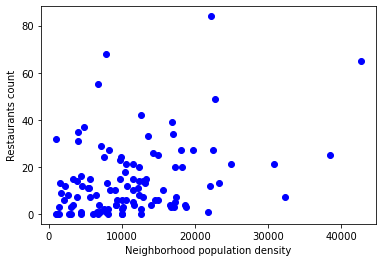

In [449]:
# Plot 
plt.scatter(LA_df['Population density'], LA_df['Restaurants count'],  color='blue')
plt.xlabel("Neighborhood population density")
plt.ylabel("Restaurants count")
plt.show()

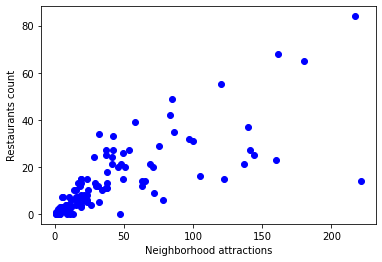

In [450]:
# Plot 
plt.scatter(LA_df['Total attractions'], LA_df['Restaurants count'],  color='blue')
plt.xlabel("Neighborhood attractions")
plt.ylabel("Restaurants count")
plt.show()

In [451]:
# CLUSTERING NEIGHBORHOODS
# Now we will start the process of clustering the neighborhoods

# We select the population density and the total number of attractions as features for clustering
selected_features = ['Population density','Total attractions']
LA_selected = LA_df[selected_features]

# We normalize the dataframe before running k-means
LA_clustering = StandardScaler().fit_transform(LA_selected)

# k-means clustering
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_clustering)


In [452]:
# Insert the labels in the original dataframe
LA_df.insert(1, 'Cluster label', kmeans.labels_)

# LA_df.drop(['Cluster Label'], axis=1, inplace=True)
display_features = ['Neighborhood','Cluster label','Population density','Total attractions','Restaurants count','Lebanese restaurants count']
LA_df[display_features]

,Neighborhood,Cluster label,Population density,Total attractions,Restaurants count,Lebanese restaurants count
0,Arleta,0,10022.0,6,2,0
1,Arlington Heights,2,22106.0,31,12,0
2,Atwater Village,0,8271.0,54,27,0
3,Baldwin Hills/Crenshaw,0,10041.0,3,0,0
4,Bel Air,0,1201.0,1,0,0
5,Beverly Crest,0,1343.0,2,0,0
6,Beverly Grove,1,12598.0,83,42,1
7,Beverlywood,0,7600.0,2,2,0
8,Boyle Heights,2,14275.0,49,26,0
9,Brentwood,1,2062.0,78,6,0


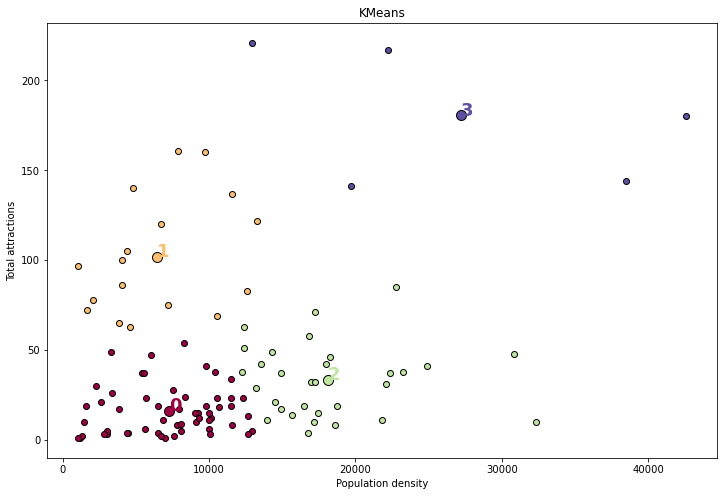

In [453]:
# Let us visualize the clustering with a plot
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(12, 8))

X = LA_df['Population density']
Y = LA_df['Total attractions']

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(kmeans.labels_) to get the
# unique labels.
colors_array = plt.cm.Spectral(np.linspace(0, 1, len(set(kmeans.labels_))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len(kmeans.cluster_centers_)), colors_array):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (kmeans.labels_ == k)
    
    # Define the centroid, or cluster center.
    cluster_center = [mean(X[my_members]) , mean(Y[my_members])]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members], Y[my_members], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
    
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=10)    
    ax.text(cluster_center[0], cluster_center[1], str(k), color=col, fontdict={'weight': 'bold', 'size': 18})

# Title of the plot
ax.set_title('KMeans')

plt.xlabel("Population density")
plt.ylabel("Total attractions")

# Show the plot
plt.show()

In [454]:
# Cluster 0
LA_df.loc[LA_df['Cluster label'] == 0, display_features]

,Neighborhood,Cluster label,Population density,Total attractions,Restaurants count,Lebanese restaurants count
0,Arleta,0,10022.0,6,2,0
2,Atwater Village,0,8271.0,54,27,0
3,Baldwin Hills/Crenshaw,0,10041.0,3,0,0
4,Bel Air,0,1201.0,1,0,0
5,Beverly Crest,0,1343.0,2,0,0
7,Beverlywood,0,7600.0,2,2,0
10,Broadway Manchester,0,1467.0,10,3,0
15,Chatsworth,0,2255.0,30,12,0
16,Chesterfield Square,0,10103.0,12,3,0
17,Cheviot Hills,0,4443.0,4,1,0


In [455]:
# Cluster 1
LA_df.loc[LA_df['Cluster label'] == 1, display_features]

,Neighborhood,Cluster label,Population density,Total attractions,Restaurants count,Lebanese restaurants count
6,Beverly Grove,1,12598.0,83,42,1
9,Brentwood,1,2062.0,78,6,0
12,Carthay,1,9732.0,160,23,0
14,Century City,1,7876.0,161,68,2
21,Downtown,1,4803.0,140,37,0
28,Encino,1,4411.0,105,16,1
64,Pacific Palisades,1,1055.0,97,32,0
71,Playa Vista,1,1642.0,72,9,0
74,Reseda,1,10538.0,69,21,0
75,San Pedro,1,7193.0,75,29,1


In [456]:
# Cluster 2
LA_df.loc[LA_df['Cluster label'] == 2, display_features]

,Neighborhood,Cluster label,Population density,Total attractions,Restaurants count,Lebanese restaurants count
1,Arlington Heights,2,22106.0,31,12,0
8,Boyle Heights,2,14275.0,49,26,0
11,Canoga Park,2,12378.0,63,14,0
13,Central Alameda,2,18612.0,8,4,0
18,Chinatown,2,22751.0,85,49,0
19,Cypress Park,2,13949.0,11,4,0
23,East Hollywood,2,30820.0,48,21,2
24,Echo Park,2,16856.0,58,39,0
29,Exposition Park,2,17257.0,71,20,0
31,Florence,2,15648.0,14,10,0


In [457]:
# Cluster 3
LA_df.loc[LA_df['Cluster label'] == 3, display_features]

,Neighborhood,Cluster label,Population density,Total attractions,Restaurants count,Lebanese restaurants count
42,Hollywood,3,22234.0,217,84,1
47,Koreatown,3,42619.0,180,65,0
88,University Park,3,19663.0,141,27,0
102,West Los Angeles,3,38459.0,144,25,2
103,Westwood,3,12950.0,221,14,0


In [458]:
# create map of Los Angeles using latitude and longitude values
map_clusters = folium.Map(location=[LA_latitude, LA_longitude], zoom_start=10)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, neighborhood, cluster, pop in zip(LA_df['Latitude'], LA_df['Longitude'], LA_df['Neighborhood'], LA_df['Cluster label'], LA_df['Population density']):
    label = folium.Popup('{}, Cluster {}'.format(neighborhood, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 5 * (pop / 10000),
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  
    
map_clusters

In total, we can observe the following about the 4 clusters of neighborhoods:
-	Cluster 0: contains the neighborhoods with low population density and low number of attractions
-	Cluster 1: contains the neighborhoods with high number of attractions but relatively low population density 
-	Cluster 2: contains the neighborhoods with high population density but relatively low number of attractions 
-	Cluster 3: contains the neighborhoods with high population density and high number of attractions

Discussion:
The problem was: where to place the new Lebanese restaurant in the city ?
Now looking at the clusters, we can say that in order to have the best potential to success and eventually higher revenues, Fadi should find a place in one of the neighborhoods of cluster 3: Hollywood, Koreatown, University Park, West Los Angeles, or Westwood
 
Among these neighborhoods, he might avoid Hollywood and West Los Angeles if he desires to avoid competition from same type restaurant. Moreover, if he’s looking for a place with not much restaurants in general, he might go for University Park or Westwood, rather than Koreatown.

What if it is too hard to find a place for restaurant in these neighborhoods, or it’s beyond the budget of Fadi? In this case, he can opt out for one of the neighborhoods in cluster 1 if he would like to target visitors/tourists, or one from cluster 2 if he would like to target the local population.

Finally the neighborhoods in cluster 0 will present the least potential, since they have lower population density and attractions to attract visitors and tourists. Therefore, he should better avoid this cluster.
